# Modeling Complex Systems Final Project
## Mish Wilson and Cooper Sullivan
11/27/2024

In [8]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import math

In [143]:
# Creating intial random networks
social_net = nx.Graph()

# Create 'n' number of nodes all starting out alive
n = 10
init_nodes = [(i, dict(status="alive")) for i in range(n)]
# print(init_nodes)

# Choose 1 node randomly to be the imposter and set its status to reflect this
imposter_idx = random.choice(range(0, len(init_nodes)))
init_nodes[imposter_idx][1]["status"] = "imposter"
# print(init_nodes[imposter_idx])

# Add all these nodes to our network graph
social_net.add_nodes_from(init_nodes)


# Create edges for each. All start at trust = 100% and arbitrary equal distance
init_edges = []
sus_edges = []
for i in range(0, len(init_nodes)):
    # Since edges arent directed we only need to add edges from one node to another, not both ways
    for j in range(i, len(init_nodes)):
        
        # Check to ensure nodes are different to avoid self edges
        if i != j:

            # Imposter node keeps track of edges seperately for formatting
            if j == imposter_idx or i == imposter_idx:
                sus_edges.append((i, j, dict(trust=1, distance=10)))
            else:
                init_edges.append((i, j, dict(trust=1, distance=10)))


# Add these edges to network
social_net.add_edges_from(init_edges)
social_net.add_edges_from(sus_edges)

In [144]:
# Function to display network
def draw_network():

    pos = nx.spring_layout(social_net)

    for i in social_net.nodes:

        nx.draw_networkx_edges(social_net, pos=pos, edgelist=init_edges, edge_color="tab:blue", alpha=0.5)
        nx.draw_networkx_edges(social_net, pos=pos, edgelist=sus_edges, edge_color="tab:red", alpha=1)
        
        if nx.get_node_attributes(social_net, "status")[i] == "imposter":
            
            nx.draw_networkx_nodes(social_net, pos=pos, nodelist=[i], node_color="tab:red")
        
        else:
            nx.draw_networkx_nodes(social_net, pos=pos, nodelist=[i], node_color="tab:blue")

        labels = nx.draw_networkx_labels(social_net, pos=pos)

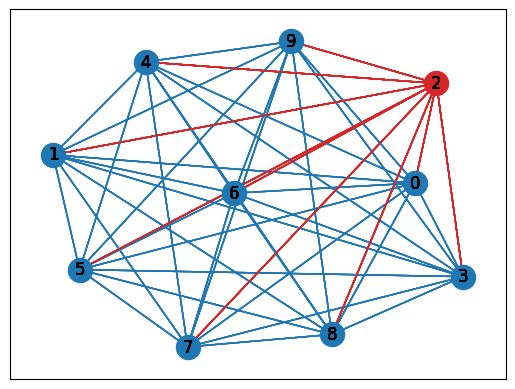

In [145]:
draw_network()

### Parameters for the system

- $epochs$ is the number of iterations to run the model for. We can think of these timesteps as days for the sake of imagination.
- $alpha$ represents the imposter's anger level. It's used to increase the aggressive behaviour of imposter by having higher base chance of wanting to kill.
- $beta$ represents the rate at which the imposter will lose their patience. It is influenced by the time since last kill.
- $time\_since\_prev\_kill$ keeps track of the number of epochs that occur without a kill.
- $max\_dist$ is the maximum distance a node can move from its surroundings (this exists so we can normalize the avg distance)
- $invnorm\_dist$ is the average distance between all nodes, which we normalize and then invert so that when everyone is grouped up (avg_dist = 0) the imposter will be able to throw other people under suspicion better and therefore is more likely to kill.

In [ ]:
# Params: See above for explanations

epochs = 20
alpha = 0.5
beta = 0.1
time_since_prev_kill = 0
max_dist = 20
avg_dist = nx.average_shortest_path_length(social_net, weight="distance")
invnorm_dist = 1 - (avg_dist/ (max_dist))


# Use for loop to iterate through epochs (go through each day and see changes)
for t in range(0, epochs):

    # randomly update distances with slight bias to trusted nodes
    # for i in nodes:
    #     for j in nodes:
    #         if trust > trust_threshold:
    #             get closer. amount scales with level of trust?
    #         else:
    #             move away. amount scales with trust


    # random chance that imposter kills close by node
    kill_prob = invnorm_dist * alpha * beta * time_since_prev_kill

    print(f"kill_prob = {kill_prob:.0%}%")

    #   choose node from alive subset
    #   set node to deceased


    # if no kill was made increment time_since_prev_kill by 1
    time_since_prev_kill += 1

# 

kill_prob = 0%%
kill_prob = 2%%
kill_prob = 5%%
kill_prob = 8%%
kill_prob = 10%%
kill_prob = 12%%
kill_prob = 15%%
kill_prob = 18%%
kill_prob = 20%%
kill_prob = 22%%
kill_prob = 25%%
kill_prob = 28%%
kill_prob = 30%%
kill_prob = 32%%
kill_prob = 35%%
kill_prob = 38%%
kill_prob = 40%%
kill_prob = 43%%
kill_prob = 45%%
kill_prob = 48%%
